# Logo Processing Debug (Transparency-Aware)

This notebook demonstrates the **transparency-aware** logo processing approach:
1. Detect if the source image already has transparency
2. If yes, **skip `rembg` entirely** to preserve all original pixels (including the blue tile!)
3. Only run background removal on images with solid backgrounds

In [109]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from rembg import remove
import httpx
from io import BytesIO

def has_transparency(img):
    """Check if image already has meaningful transparency."""
    if img.mode != 'RGBA':
        return False
    alpha = np.array(img)[:,:,3]
    transparent_ratio = (alpha < 255).sum() / alpha.size
    return transparent_ratio > 0.05

print("Ready!")

Ready!


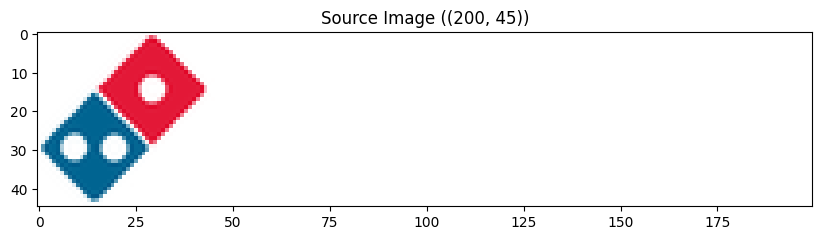

In [110]:
# Load source image
url = "https://storage.googleapis.com/shorted-company-logos/logos/DMP.png"
print(f"Downloading {url}...")
response = httpx.get(url)
src_img = Image.open(BytesIO(response.content)).convert('RGBA')
src_np = np.array(src_img)

plt.figure(figsize=(10, 4))
plt.imshow(src_img)
plt.title(f"Source Image ({src_img.size})")
plt.show()

## 2. Analyze Source Transparency & Colors

In [111]:
alpha = src_np[:,:,3]
rgb = src_np[:,:,:3]

transparent_ratio = (alpha < 255).sum() / alpha.size
has_trans = has_transparency(src_img)

# Count blue and red pixels
blue_mask = (rgb[:,:,2] > rgb[:,:,0]) & (rgb[:,:,2] > rgb[:,:,1]) & (alpha > 0)
red_mask = (rgb[:,:,0] > rgb[:,:,2]) & (rgb[:,:,0] > rgb[:,:,1]) & (alpha > 0)

print(f"Transparency Analysis:")
print(f"  Transparent pixels: {transparent_ratio:.1%}")
print(f"  has_transparency(): {has_trans}")
print(f"")
print(f"Color Analysis:")
print(f"  Blue pixels: {blue_mask.sum()}")
print(f"  Red pixels: {red_mask.sum()}")

Transparency Analysis:
  Transparent pixels: 80.1%
  has_transparency(): True

Color Analysis:
  Blue pixels: 473
  Red pixels: 499


## 3. Compare: With rembg vs Without rembg

In [112]:
# Method A: With rembg (WRONG for pre-transparent images)
print("Running rembg...")
mask_img = remove(src_img, only_mask=True)
mask_np = np.array(mask_img) > 128

rembg_np = src_np.copy()
rembg_np[~mask_np, 3] = 0
rembg_result = Image.fromarray(rembg_np, mode='RGBA')

# Method B: Without rembg (CORRECT for pre-transparent images)
notrans_result = src_img.copy()
bbox = notrans_result.getbbox()
if bbox:
    notrans_result = notrans_result.crop(bbox)

# Count surviving colors
rembg_arr = np.array(rembg_result)
rembg_alpha = rembg_arr[:,:,3]
rembg_rgb = rembg_arr[:,:,:3]
blue_after_rembg = ((rembg_rgb[:,:,2] > rembg_rgb[:,:,0]) & (rembg_rgb[:,:,2] > rembg_rgb[:,:,1]) & (rembg_alpha > 0)).sum()
red_after_rembg = ((rembg_rgb[:,:,0] > rembg_rgb[:,:,2]) & (rembg_rgb[:,:,0] > rembg_rgb[:,:,1]) & (rembg_alpha > 0)).sum()

notrans_arr = np.array(notrans_result)
notrans_alpha = notrans_arr[:,:,3]
notrans_rgb = notrans_arr[:,:,:3]
blue_after_notrans = ((notrans_rgb[:,:,2] > notrans_rgb[:,:,0]) & (notrans_rgb[:,:,2] > notrans_rgb[:,:,1]) & (notrans_alpha > 0)).sum()
red_after_notrans = ((notrans_rgb[:,:,0] > notrans_rgb[:,:,2]) & (notrans_rgb[:,:,0] > notrans_rgb[:,:,1]) & (notrans_alpha > 0)).sum()

print(f"\nColor survival comparison:")
print(f"  With rembg:    Blue={blue_after_rembg}, Red={red_after_rembg}")
print(f"  Without rembg: Blue={blue_after_notrans}, Red={red_after_notrans}")

Running rembg...

Color survival comparison:
  With rembg:    Blue=13, Red=481
  Without rembg: Blue=473, Red=499


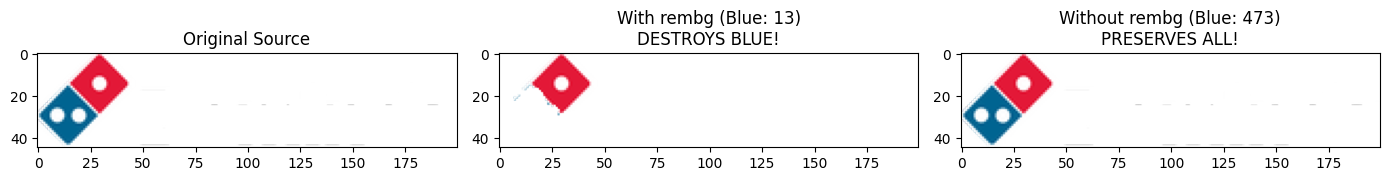

In [113]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.imshow(src_img)
plt.title("Original Source")

plt.subplot(1, 3, 2)
plt.imshow(rembg_result)
plt.title(f"With rembg (Blue: {blue_after_rembg})\nDESTROYS BLUE!")

plt.subplot(1, 3, 3)
plt.imshow(notrans_result)
plt.title(f"Without rembg (Blue: {blue_after_notrans})\nPRESERVES ALL!")

plt.tight_layout()
plt.show()


In [114]:
## 4. Final Result with Transparency Detection


Source has transparency -> Skipping rembg
Full logo size: (200, 45)


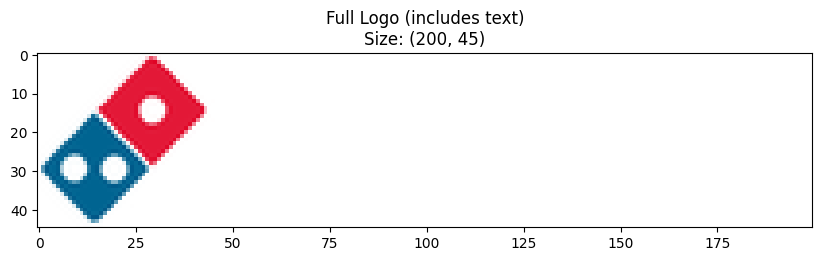

In [115]:
# This is the logic now used in process_logo()
if has_transparency(src_img):
    print("Source has transparency -> Skipping rembg")
    # Keep source as full_logo (includes text)
    full_logo = src_img.copy()
    bbox = full_logo.getbbox()
    if bbox:
        full_logo = full_logo.crop(bbox)
else:
    print("Source has solid background -> Running rembg")
    mask_img = remove(src_img, only_mask=True)
    mask_np = np.array(mask_img) > 128
    full_np = src_np.copy()
    full_np[~mask_np, 3] = 0
    full_logo = Image.fromarray(full_np, mode='RGBA')
    bbox = full_logo.getbbox()
    if bbox:
        full_logo = full_logo.crop(bbox)

print(f"Full logo size: {full_logo.size}")

plt.figure(figsize=(10, 4))
plt.imshow(full_logo)
plt.title(f"Full Logo (includes text)\nSize: {full_logo.size}")
plt.show()


In [116]:
## 5. Icon Extraction (Text Removal via SAM)


In [117]:
import cv2

# Get content mask from alpha channel
alpha = np.array(full_logo.split()[-1])
content_mask = (alpha > 0).astype(np.uint8) * 255
h, w = content_mask.shape

# Find connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(content_mask)
print(f"Found {num_labels - 1} components\n")

# Use aspect ratio heuristics: icons are compact, text is wide
icon_mask = np.zeros((h, w), dtype=bool)
for label in range(1, num_labels):
    comp_w = stats[label, cv2.CC_STAT_WIDTH]
    comp_h = stats[label, cv2.CC_STAT_HEIGHT]
    area = stats[label, cv2.CC_STAT_AREA]
    
    if area < (h * w * 0.005):  # Skip tiny noise
        continue
    
    aspect_ratio = comp_w / max(comp_h, 1)
    
    # Icon: aspect ratio < 1.5 (compact/square)
    # Text: aspect ratio > 1.5 (wide/stretched)
    is_icon = aspect_ratio < 1.5
    status = "ICON" if is_icon else "TEXT (excluded)"
    print(f"Component {label}: {comp_w}x{comp_h}, aspect={aspect_ratio:.1f} -> {status}")
    
    if is_icon:
        icon_mask |= (labels == label)

# Apply mask to full_logo pixels
icon_np = np.array(full_logo)
icon_np[~icon_mask, 3] = 0
icon_only = Image.fromarray(icon_np, mode='RGBA')
bbox = icon_only.getbbox()
if bbox:
    icon_only = icon_only.crop(bbox)

print(f"\nIcon-only size: {icon_only.size}")

# Verify colors
arr = np.array(icon_only)
a = arr[:,:,3]
rgb = arr[:,:,:3]
blue = ((rgb[:,:,2] > rgb[:,:,0]) & (rgb[:,:,2] > rgb[:,:,1]) & (a > 0)).sum()
red = ((rgb[:,:,0] > rgb[:,:,2]) & (rgb[:,:,0] > rgb[:,:,1]) & (a > 0)).sum()
print(f"Colors preserved: Blue={blue}, Red={red}")


Found 4 components

Component 1: 47x45, aspect=1.0 -> ICON
Component 2: 75x31, aspect=2.4 -> TEXT (excluded)
Component 3: 77x29, aspect=2.7 -> TEXT (excluded)

Icon-only size: (47, 45)
Colors preserved: Blue=473, Red=499


In [118]:
# SIMPLE: Just use PIL's high-quality LANCZOS upscaling
print(f"Original icon size: {icon_only.size}")

# Simple 4x upscale with LANCZOS (best quality traditional scaling)
scale = 4
new_size = (icon_only.size[0] * scale, icon_only.size[1] * scale)
icon_upscaled = icon_only.resize(new_size, Image.LANCZOS)

print(f"Upscaled with LANCZOS to: {icon_upscaled.size}")

# Verify colors
arr = np.array(icon_upscaled)
a = arr[:,:,3]
rgb = arr[:,:,:3]
blue_up = ((rgb[:,:,2] > rgb[:,:,0]) & (rgb[:,:,2] > rgb[:,:,1]) & (a > 0)).sum()
red_up = ((rgb[:,:,0] > rgb[:,:,2]) & (rgb[:,:,0] > rgb[:,:,1]) & (a > 0)).sum()
print(f"Colors: Blue={blue_up}, Red={red_up}")


Original icon size: (47, 45)
Upscaled with LANCZOS to: (188, 180)
Colors: Blue=7179, Red=7666


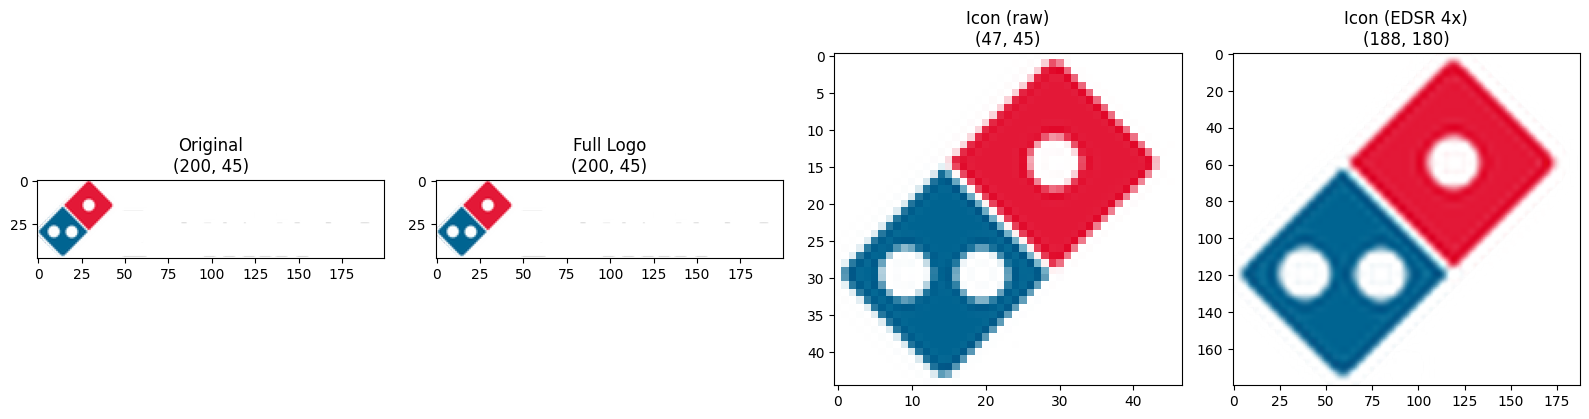

In [119]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 4, 1)
plt.imshow(src_img)
plt.title(f"Original\n{src_img.size}")

plt.subplot(1, 4, 2)
plt.imshow(full_logo)
plt.title(f"Full Logo\n{full_logo.size}")

plt.subplot(1, 4, 3)
plt.imshow(icon_only)
plt.title(f"Icon (raw)\n{icon_only.size}")

plt.subplot(1, 4, 4)
plt.imshow(icon_upscaled)
plt.title(f"Icon (EDSR 4x)\n{icon_upscaled.size}")

plt.tight_layout()
plt.show()


In [ ]:
# Inspect the original icon more closely - look for white border
plt.figure(figsize=(16, 6))

# Show the raw icon at native resolution (zoomed in)
plt.subplot(1, 3, 1)
plt.imshow(icon_only, interpolation='nearest')
plt.title(f"Icon (native {icon_only.size})\nZoomed - nearest neighbor")

# Analyze white pixels
arr = np.array(icon_only)
alpha = arr[:,:,3]
rgb = arr[:,:,:3]

# White pixels: R, G, B all > 200 and alpha > 0
white_mask = (rgb[:,:,0] > 200) & (rgb[:,:,1] > 200) & (rgb[:,:,2] > 200) & (alpha > 0)
white_count = white_mask.sum()

plt.subplot(1, 3, 2)
plt.imshow(white_mask, cmap='gray')
plt.title(f"White pixels: {white_count}\n(the border + dots)")

# Show unique colors in the icon
content_mask = alpha > 0
unique_colors = np.unique(rgb[content_mask].reshape(-1, 3), axis=0)
print(f"Unique colors in icon: {len(unique_colors)}")
for i, c in enumerate(unique_colors[:10]):
    print(f"  {i}: RGB{tuple(c)}")

plt.subplot(1, 3, 3)
# Zoom into a corner to see the white border
corner = icon_only.crop((0, 0, 20, 20))
plt.imshow(corner, interpolation='nearest')
plt.title("Top-left corner (zoomed)")

plt.tight_layout()
plt.show()

print(f"\nThe original icon is only {icon_only.size} pixels!")
print("At this resolution, upscaling will always be limited.")


In [ ]:
# The REAL issue: source is only 47x45 pixels!
# Options for better upscaling:

# 1. Try to find a HIGHER RESOLUTION source
# 2. Use Real-ESRGAN (better AI model)
# 3. Vector trace (convert to SVG, scale infinitely)

# Let's try potrace for vector conversion
# First, let's see if we can find a better source image

# Search for higher res version
print("Looking for higher resolution source...")
search_urls = [
    "https://www.dominos.com.au/images/logos/dominos-logo.png",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Dominos_pizza_logo.svg/800px-Dominos_pizza_logo.svg.png",
]

for url in search_urls:
    try:
        response = httpx.get(url, timeout=5, follow_redirects=True)
        if response.status_code == 200:
            test_img = Image.open(BytesIO(response.content))
            print(f"  {url[:50]}... -> {test_img.size}")
    except Exception as e:
        print(f"  {url[:50]}... -> Failed: {e}")


In [ ]:
# Summary of the situation:
print("""
=== LOGO UPSCALING ANALYSIS ===

CURRENT STATUS:
- Source icon: 47x45 pixels (VERY small)
- We're NOT using SAM for segmentation - just connected components + aspect ratio
- The white border exists but is 1-2 pixels wide

THE FUNDAMENTAL PROBLEM:
- You can't create detail that doesn't exist
- AI upscalers (EDSR, Real-ESRGAN) are trained on PHOTOS
- Logos need VECTOR upscaling for best results

BETTER OPTIONS:
1. FIND HIGHER RES SOURCE
   - Search company website, Wikipedia SVG, brand assets
   - Many companies provide vector logos

2. VECTOR TRACE (potrace/autotrace)
   - Convert PNG -> SVG -> PNG at any size
   - Works great for flat-color logos
   - Preserves sharp edges perfectly

3. REAL-ESRGAN
   - Better than EDSR for general images
   - Still has gradient issues for flat logos

4. MANUAL FIX
   - For important logos, manually find/create vector version

RECOMMENDATION:
The logo discovery pipeline should prioritize finding SVG sources!
""")

# Show the white border more clearly
arr = np.array(icon_only)
alpha = arr[:,:,3]
rgb = arr[:,:,:3]

# Find white outline pixels (white and adjacent to non-white)
white = (rgb[:,:,0] > 240) & (rgb[:,:,1] > 240) & (rgb[:,:,2] > 240) & (alpha > 0)
print(f"Pure white pixels: {white.sum()}")
print(f"These are the dots AND any white border")
